# Machine Learning Project
## QuickDraw

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.utils.np_utils import to_categorical
from keras import optimizers, Input
from keras.models import Sequential
from tensorflow.keras import layers
from keras.layers import Dense, Activation, Flatten, Conv2D,MaxPooling2D
import scipy.ndimage.interpolation as interpolation

from sklearn import svm
from sklearn.svm import SVC
from sklearn.datasets import make_blobs, make_circles
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from scipy.stats import multivariate_normal
from sklearn import metrics
from sklearn.model_selection import StratifiedShuffleSplit
from time import time
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.decomposition import PCA

# **Creation of the datasets**

In [ ]:
ants_data = np.load('G_15_ant.npy')
grapes_data = np.load('G_15_grapes.npy')
test_images = np.load('test_images.npy')
test_label = np.load('test_labels.npy')

In [ ]:
print("There are ", len(ants_data), "images of ants")
print("There are ", len(grapes_data), "images of grapes") 

There are  1000 images of ants
There are  1000 images of grapes


In [ ]:
train_images = np.concatenate((ants_data, grapes_data))
ants_label = np.array([0]*1000)
grapes_label = np.array([1]*1000)
train_label = np.concatenate((ants_label, grapes_label))

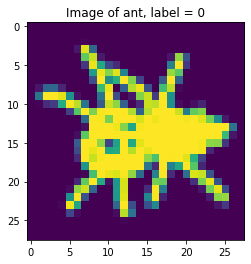

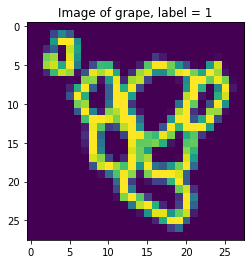

In [ ]:
plt.imshow(ants_data[0].reshape(28,28))
plt.title("Image of ant, label = 0")
plt.show()
plt.imshow(grapes_data[0].reshape(28,28))
plt.title("Image of grape, label = 1")
plt.show()

In this data set we have 1000 images of ants and 1000 images of grapes. We put all of them in train_images and label ants with 0, grapes with 1. The labels are in train_label.

# **PART ONE : SUPPORT VECTOR MACHINE**

## **Tests for different kind of kernels**

In [ ]:
# fit the model with linear kernel
clf_lin = SVC(kernel='linear')
clf_lin.fit(train_images, train_label)

# predict labels for the test data base
y_pred = clf_lin.predict(test_images)

# check your score
score_lin = clf_lin.score(test_images, test_label)
print('Score with a linear kernel: %s' % score_lin)

Score with a linear kernel: 0.696


In [ ]:
# fit the model with rbf kernel
clf_rbf = SVC(kernel='rbf')
clf_rbf.fit(train_images, train_label)

# predict labels for the test data base
y_pred = clf_rbf.predict(test_images)

# check your score
score_rbf = clf_rbf.score(test_images, test_label)
print('Score with a rbf kernel: %s' % score_rbf)

Score with a rbf kernel: 0.867


In [ ]:
# fit the model with polynomial kernel
clf_poly = SVC(kernel='poly')
clf_poly.fit(train_images, train_label)

# predict labels for the test data base
y_pred_poly = clf_poly.predict(test_images)

# check your score
score_poly = clf_poly.score(test_images, test_label)
print('Score with a poly kernel: %s' % score_poly)

Score with a poly kernel: 0.847


After trying with different kernels we can see that the best score 0.867 is obtained with a rbf kernel. We are going to compare more precisely the differences between the performance of the different kernels. 

## **Summary of the performance for different kernels**

t_linear 26.1480131149292
t_poly 4.269855976104736
t_rbf 4.287829160690308
rbf kernel  : 1226.00 support vectors
poly kernel  : 1247.00 support vectors
linear kernel  : 610.00 support vectors
rbf kernel : accuracy score is 0.87 
poly kernel : accuracy score is 0.86 
linear kernel : accuracy score is 0.70 


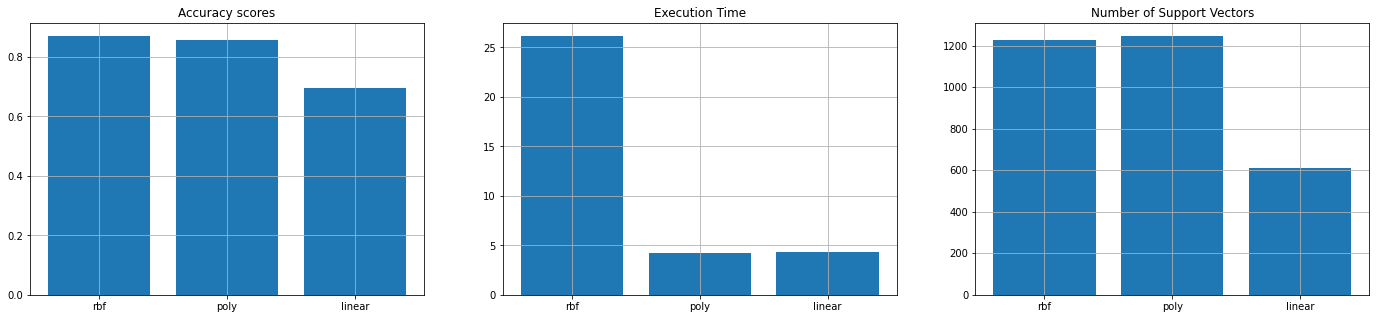

In [ ]:
nb_support_vector = []
acc_score = []
times = []
c = 10
########### We compute the time of execution
t0 = time()
clf_linear = svm.SVC(kernel='linear', C=c)
clf_linear.fit(train_images, train_label)
t_linear = time()-t0
times.append(t_linear)
print("t_linear", t_linear)
t0 = time()

clf_poly = svm.SVC(kernel = 'poly', C=c)
clf_poly.fit(train_images, train_label)
t_poly = time()-t0
times.append(t_poly)
print("t_poly", t_poly)

t0 = time()
clf_rbf = svm.SVC(kernel='rbf', C=c)
clf_rbf.fit(train_images, train_label)
t_rbf = time()-t0
times.append(t_rbf)
print("t_rbf", t_rbf)

clf_range = [clf_rbf, clf_poly, clf_linear]

############# We compute the number of support vectors for each type of kernel.
for clf in clf_range : 
  nb_support_vector.append(len(clf.support_vectors_))
  print("%s kernel  : %0.2f support vectors" %(clf.kernel , len(clf.support_vectors_)))

############# We compute the accuracy score for each type of kernel.

for clf in clf_range : 
    predicted = clf.predict(test_images)
    score = metrics.accuracy_score(test_label, predicted)
    acc_score.append(score)
    print("%s kernel : accuracy score is %0.2f " %(clf.kernel, score))

##### Plot for a better view
_, axes = plt.subplots(1, 3, figsize=(24, 5))

axes[0].set_title("Accuracy scores")
axes[0].grid()
axes[0].bar(["rbf", "poly", "linear"],acc_score)

axes[1].set_title("Execution Time")
axes[1].grid()
axes[1].bar(["rbf", "poly", "linear"],times)

axes[2].set_title("Number of Support Vectors")
axes[2].grid()
axes[2].bar(["rbf", "poly", "linear"], nb_support_vector)
plt.show()

The poly and linear kernel have quite close scores and number of Support Vectors. The rbf kernel is more than 5 times slower than the others. 

In [ ]:
##We compute the confusion matrix for each type of kernel. 

for clf in clf_range : 
    predicted = clf.predict(test_images)
    matrix = metrics.confusion_matrix(test_label, predicted)
    print("%s kernel" %(clf.kernel), matrix)

rbf kernel [[434  66]
 [ 63 437]]
poly kernel [[444  56]
 [ 88 412]]
linear kernel [[340 160]
 [144 356]]


The diagonal line from the top-left corner to the bottom-right corner is the number of correct predictions for each row. Each row corresponding to a class. The best model, as far as the accuracy score is concerned, is the rbf kernel it gives the best prediction.

## **Study of the influence of parameters gamma and C**

In [ ]:
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)

In [ ]:
grid.fit(train_images, train_label)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

The best parameters are {'C': 1.0, 'gamma': 1e-07} with a score of 0.87


In [ ]:
import matplotlib as mpl

class MidpointNormalize( mpl.colors.Normalize ):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

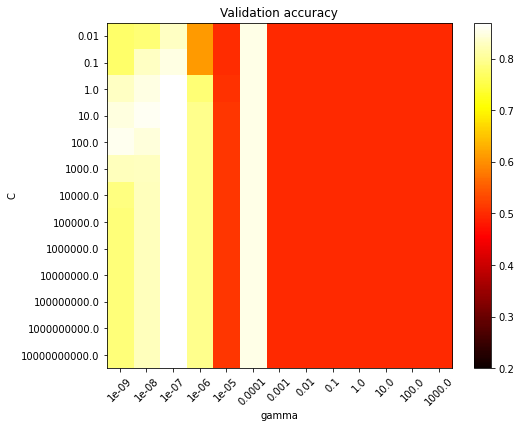

In [ ]:
scores = grid.cv_results_['mean_test_score'].reshape(len(C_range),len(gamma_range))

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot, norm= MidpointNormalize(vmin=0.2, midpoint=0.55))
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Validation accuracy')
plt.show()


This heatmap represents the behaviour of the validation accuracy as a function of the parameters C and gamma. 

The gamma parameter defines how far the influence of a single training example reaches. I gamma is low value this influence will be far and when it increases the influence decreases.

The C parameter trades off correct classification of training examples against maximization of the decision function’s margin. When C increases the size of the accepted margin will decrease if the decision function is better at classifying all training points correctly.

Here we see that the best score is obtained for gama = 10^-7 and C > 1. 

##  **Study of the training and testing errors**

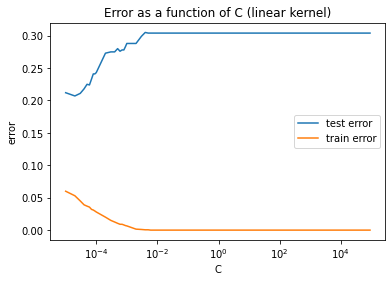

In [ ]:
C = [k*(10**i) for i in range(-5,5) for k in range(1,10)]
test_error = []
train_error = []
for i in range(len(C)):
    clf = svm.SVC(kernel='linear', C=C[i])
    clf.fit(train_images, train_label)
    test_error.append(1-clf.score(test_images, test_label))
    train_error.append(1-clf.score(train_images, train_label))
plt.plot(C, test_error , label = 'test error')
plt.plot(C, train_error, label = 'train error')
plt.xscale("log")
plt.xlabel("C")
plt.ylabel("error")
plt.legend()
plt.title("Error as a function of C (linear kernel)")
plt.show()

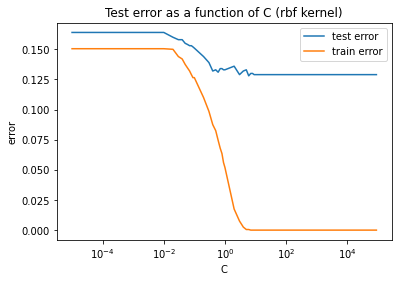

In [ ]:
C = [k*(10**i) for i in range(-5,5) for k in range(1,10)]
test_error = []
train_error = []
for i in range(len(C)):
    clf = svm.SVC(kernel='rbf', C=C[i])
    clf.fit(train_images, train_label)
    test_error.append(1-clf.score(test_images, test_label))
    train_error.append(1-clf.score(train_images, train_label))
plt.plot(C, test_error, label = 'test error')
plt.plot(C, train_error, label = 'train error')
plt.xscale("log")
plt.xlabel("C")
plt.ylabel("error")
plt.legend()
plt.title("Test error as a function of C (rbf kernel)")
plt.show()

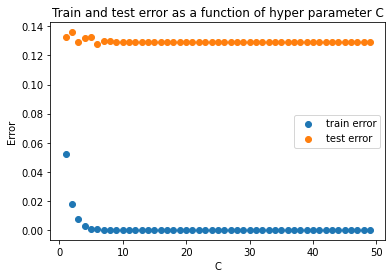

In [ ]:
#C is the hyper-parameter controlling the complexity, 
#We draw the train and test error as a function of C

C_range = np.arange(1,50,1)
train_error=[]
test_error=[]
for c in C_range:
    clf_rbf = svm.SVC(kernel='rbf', C=c)
    clf_rbf.fit(train_images, train_label)
    train_error.append(1-clf_rbf.score(train_images, train_label))
    test_error.append(1-clf_rbf.score(test_images, test_label))


plt.scatter(C_range, train_error, label='train error')
plt.scatter(C_range, test_error, label='test error')
plt.xlabel("C")
plt.ylabel("Error")
plt.legend()
plt.title("Train and test error as a function of hyper parameter C")
plt.show()

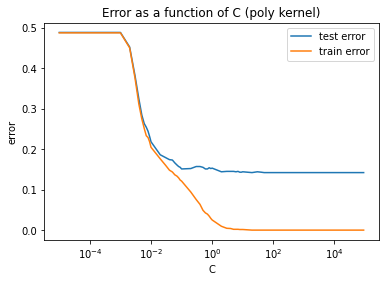

In [ ]:
C = [k*(10**i) for i in range(-5,5) for k in range(1,10)]
test_error = []
train_error = []
for i in range(len(C)):
    clf = svm.SVC(kernel='poly', C=C[i])
    clf.fit(train_images, train_label)
    test_error.append(1-clf.score(test_images, test_label))
    train_error.append(1-clf.score(train_images, train_label))
plt.plot(C, test_error, label = 'test error')
plt.plot(C, train_error, label = 'train error')
plt.xscale("log")
plt.xlabel("C")
plt.ylabel("error")
plt.legend()
plt.title("Error as a function of C (poly kernel)")
plt.show()

For the poly and rbf kernel when we plot the test error with respect to C we can see that when C is high enough the test error tends to decrease. It is the lowest for the rbf kernel as expected. 

##**Influence of PCA**

In [ ]:
#score with a linear kernel
clf_linear = svm.SVC(kernel='linear')
clf_linear.fit(train_images, train_label)
print("Score with a linear kernel : ", clf_linear.score(test_images, test_label))

#We do the PCA
pca = PCA(int(train_images.shape[0]*0.3))
train_images_pca = pca.fit_transform(train_images)
test_images_pca = pca.fit_transform(test_images)

#We choose a rbf kernel
clf_rbf = svm.SVC(kernel='rbf')
clf_rbf.fit(train_images, train_label)
print("Score with a rbf kernel and without PCA : ", clf_rbf.score(test_images, test_label))
clf_rbf_pca = svm.SVC(kernel='rbf')
clf_rbf_pca.fit(train_images_pca, train_label)
print("Score with a rbf kernel and with PCA : ", clf_rbf_pca.score(test_images_pca, test_label))

Score with a linear kernel :  0.696
Score with a rbf kernel and without PCA :  0.867
Score with a rbf kernel and with PCA :  0.834


The PCA doesn't improve the performance. The performance is the best for a simple rfb kernel which gives the best results.

# **PART TWO : NEURAL NETWORK**

Another way to classify the data is to use neural networks. We thus want to see if the results given by a neural network are better than with SVMs. First, we use the to_categorical function and normalize the data to prepare our neural network.

In [ ]:
# To categorical

train_labels = to_categorical(train_label, num_classes=None, dtype='float32')
test_labels = to_categorical(test_label, num_classes=None, dtype='float32')

In [ ]:
# Normalizing data

test_images = test_images.astype('float32')
train_images = train_images.astype('float32')
norm_train = (train_images - np.mean(train_images))/np.std(train_images)
norm_test = (test_images - np.mean(train_images))/np.std(train_images)

There are several parameters that influence the quality of the network given a dataset. We first decided to do one of the most basic approach of the neural network.

Note : in all the following parts, the graphics are always plotted in order: loss history, then accuracy history.

## **Basic Neural Network**

### SGD optimizer with basic parameters

The first neural network tested is with a simple Stochastic Gradient Descent optimizer, with a the default learning rate of 10e-3. 

We created only one hidden layer of 100 neurons, activated by ReLU. The output is activated by a sigmoid activation function. The batch size is 10. Finally, we made 100 epoch with a loss calculated by the function binary crossentropy.

In [ ]:
input_shape = ants_data[0].shape[0]
output_shape = 2

model = Sequential()
model.add(Dense(100, input_dim=input_shape))
model.add(Activation('relu'))
model.add(Dense(output_shape))
model.add(Activation('sigmoid'))

opt = optimizers.SGD(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

epochs = 100

history = model.fit(norm_train, train_labels,epochs=epochs, batch_size = 10,validation_data =(norm_test,test_labels))




Epoch 1/100
200/200 [==============================] - 1s 3ms/step - loss: 0.8213 - accuracy: 0.4720 - val_loss: 0.6032 - val_accuracy: 0.7120
Epoch 2/100
200/200 [==============================] - 0s 2ms/step - loss: 0.5499 - accuracy: 0.7519 - val_loss: 0.5147 - val_accuracy: 0.7750
Epoch 3/100
200/200 [==============================] - 0s 2ms/step - loss: 0.4495 - accuracy: 0.8251 - val_loss: 0.4786 - val_accuracy: 0.8040
Epoch 4/100
200/200 [==============================] - 0s 2ms/step - loss: 0.4207 - accuracy: 0.8314 - val_loss: 0.4605 - val_accuracy: 0.8130
Epoch 5/100
200/200 [==============================] - 0s 2ms/step - loss: 0.4022 - accuracy: 0.8372 - val_loss: 0.4492 - val_accuracy: 0.8200
Epoch 6/100
200/200 [==============================] - 0s 2ms/step - loss: 0.4032 - accuracy: 0.8294 - val_loss: 0.4420 - val_accuracy: 0.8230
Epoch 7/100
200/200 [==============================] - 0s 2ms/step - loss: 0.3746 - accuracy: 0.8481 - val_loss: 0.4362 - val_accuracy: 0.8270

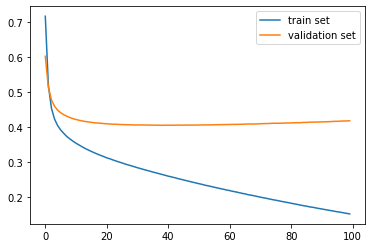

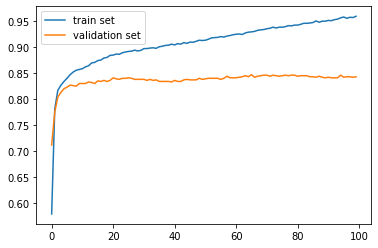

In [ ]:
# plot 

#history for loss
plt.plot(history.history["loss"],label="train set")
plt.plot(history.history["val_loss"],label="validation set")
plt.legend()
plt.show()

# summarize history for accuracy
plt.plot(history.history["accuracy"],label="train set")
plt.plot(history.history["val_accuracy"], label="validation set")
plt.legend()
plt.show()


### Learning rate

We could see that the accuracy of the previous experience was of 0,84. While not a bad result, it is not particularly outstanding either. Thus, we decide to modify some parameters in order to enhance the model. First, we try to modify the learning rate from 10e-3 to 10e-4.

In [ ]:
input_shape = ants_data[0].shape[0]
output_shape = 2

model = Sequential()
model.add(Dense(100, input_dim=input_shape))
model.add(Activation('relu'))
model.add(Dense(output_shape))
model.add(Activation('sigmoid'))

opt = optimizers.SGD(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

epochs = 100

history = model.fit(norm_train, train_labels,epochs=epochs, batch_size = 10,validation_data =(norm_test,test_labels))




Epoch 1/100
200/200 [==============================] - 1s 3ms/step - loss: 0.9503 - accuracy: 0.5331 - val_loss: 0.7986 - val_accuracy: 0.5840
Epoch 2/100
200/200 [==============================] - 0s 2ms/step - loss: 0.8037 - accuracy: 0.5929 - val_loss: 0.6961 - val_accuracy: 0.6480
Epoch 3/100
200/200 [==============================] - 0s 2ms/step - loss: 0.7153 - accuracy: 0.6481 - val_loss: 0.6376 - val_accuracy: 0.6950
Epoch 4/100
200/200 [==============================] - 0s 2ms/step - loss: 0.6420 - accuracy: 0.7008 - val_loss: 0.6019 - val_accuracy: 0.7180
Epoch 5/100
200/200 [==============================] - 0s 2ms/step - loss: 0.5972 - accuracy: 0.7354 - val_loss: 0.5782 - val_accuracy: 0.7430
Epoch 6/100
200/200 [==============================] - 0s 2ms/step - loss: 0.5976 - accuracy: 0.7331 - val_loss: 0.5609 - val_accuracy: 0.7680
Epoch 7/100
200/200 [==============================] - 0s 2ms/step - loss: 0.5477 - accuracy: 0.7667 - val_loss: 0.5473 - val_accuracy: 0.7800

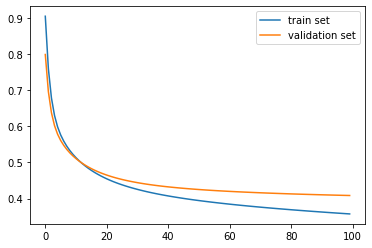

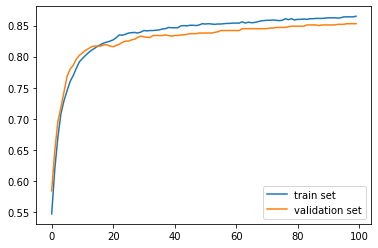

In [ ]:
# plot 

#history for loss
plt.plot(history.history["loss"],label="train set")
plt.plot(history.history["val_loss"],label="validation set")
plt.legend()
plt.show()

# summarize history for accuracy
plt.plot(history.history["accuracy"],label="train set")
plt.plot(history.history["val_accuracy"], label="validation set")
plt.legend()
plt.show()


We see that changing the learning rate increased our validation accuracy to 0.85, however this is not enough augmentation. Thus, we decide to test another optimizer.

### Optimizer

We now use the Adam optimizer with a default learning rate of 0.001. The other parameters of the neural network remain the same.

In [ ]:
input_shape = ants_data[0].shape[0]
output_shape = 2

model = Sequential()
model.add(Dense(100, input_dim=input_shape))
model.add(Activation('relu'))
model.add(Dense(output_shape))
model.add(Activation('sigmoid'))

opt = optimizers.Adam()
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

epochs = 100

history = model.fit(norm_train, train_labels,epochs=epochs, batch_size = 10,validation_data =(norm_test,test_labels))

Epoch 1/100
200/200 [==============================] - 1s 3ms/step - loss: 0.4474 - accuracy: 0.8120 - val_loss: 0.4515 - val_accuracy: 0.8100
Epoch 2/100
200/200 [==============================] - 0s 2ms/step - loss: 0.2859 - accuracy: 0.9042 - val_loss: 0.3920 - val_accuracy: 0.8450
Epoch 3/100
200/200 [==============================] - 0s 2ms/step - loss: 0.2123 - accuracy: 0.9322 - val_loss: 0.4296 - val_accuracy: 0.8500
Epoch 4/100
200/200 [==============================] - 0s 2ms/step - loss: 0.1538 - accuracy: 0.9500 - val_loss: 0.4330 - val_accuracy: 0.8450
Epoch 5/100
200/200 [==============================] - 0s 2ms/step - loss: 0.1029 - accuracy: 0.9706 - val_loss: 0.4387 - val_accuracy: 0.8440
Epoch 6/100
200/200 [==============================] - 0s 2ms/step - loss: 0.0679 - accuracy: 0.9828 - val_loss: 0.4667 - val_accuracy: 0.8520
Epoch 7/100
200/200 [==============================] - 0s 2ms/step - loss: 0.0437 - accuracy: 0.9918 - val_loss: 0.5190 - val_accuracy: 0.8490

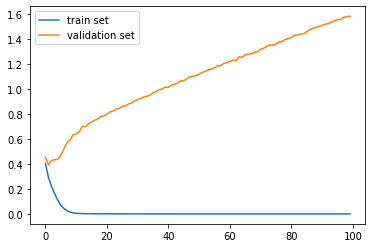

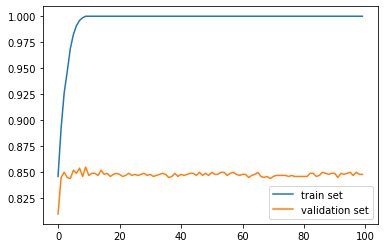

In [ ]:
# plot 

#history for loss
plt.plot(history.history["loss"],label="train set")
plt.plot(history.history["val_loss"],label="validation set")
plt.legend()
plt.show()

# summarize history for accuracy
plt.plot(history.history["accuracy"],label="train set")
plt.plot(history.history["val_accuracy"], label="validation set")
plt.legend()
plt.show()


We see that the results are still around 0.84 for the validation accuracy, however now the test accuracy is of 1 and the loss is increasing. In order to avoid overfitting, we decrease the learning rate.

### Adam's learning rate

Thus, we change Adam's learning rate from 10e-3 to 10e-4.

In [ ]:
input_shape = ants_data[0].shape[0]
output_shape = 2

model = Sequential()
model.add(Dense(100, input_dim=input_shape))
model.add(Activation('relu'))
model.add(Dense(output_shape))
model.add(Activation('sigmoid'))

opt = optimizers.Adam(learning_rate = 0.0001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

epochs = 100

history = model.fit(norm_train, train_labels,epochs=epochs, batch_size = 10,validation_data =(norm_test,test_labels))

Epoch 1/100
200/200 [==============================] - 1s 3ms/step - loss: 0.5850 - accuracy: 0.7235 - val_loss: 0.4410 - val_accuracy: 0.8300
Epoch 2/100
200/200 [==============================] - 0s 2ms/step - loss: 0.3874 - accuracy: 0.8597 - val_loss: 0.4232 - val_accuracy: 0.8380
Epoch 3/100
200/200 [==============================] - 0s 2ms/step - loss: 0.3402 - accuracy: 0.8724 - val_loss: 0.4164 - val_accuracy: 0.8450
Epoch 4/100
200/200 [==============================] - 0s 2ms/step - loss: 0.2953 - accuracy: 0.8944 - val_loss: 0.4152 - val_accuracy: 0.8400
Epoch 5/100
200/200 [==============================] - 0s 2ms/step - loss: 0.2865 - accuracy: 0.9007 - val_loss: 0.4110 - val_accuracy: 0.8440
Epoch 6/100
200/200 [==============================] - 0s 2ms/step - loss: 0.2681 - accuracy: 0.9063 - val_loss: 0.4134 - val_accuracy: 0.8420
Epoch 7/100
200/200 [==============================] - 0s 2ms/step - loss: 0.2546 - accuracy: 0.9076 - val_loss: 0.4109 - val_accuracy: 0.8430

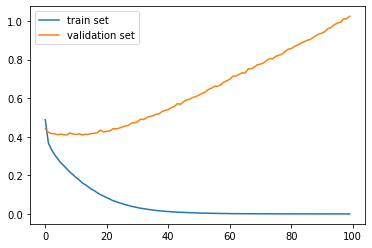

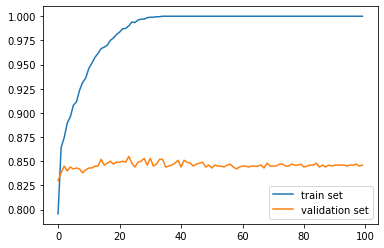

In [ ]:
# plot 

#history for loss
plt.plot(history.history["loss"],label="train set")
plt.plot(history.history["val_loss"],label="validation set")
plt.legend()
plt.show()

# summarize history for accuracy
plt.plot(history.history["accuracy"],label="train set")
plt.plot(history.history["val_accuracy"], label="validation set")
plt.legend()
plt.show()


The results stay the same, and the test accuracy is still equal to 1 and the loss is still increasing. We still try to decrease the learning rate to 10e-5.

In [ ]:
input_shape = ants_data[0].shape[0]
output_shape = 2

model = Sequential()
model.add(Dense(100, input_dim=input_shape))
model.add(Activation('relu'))
model.add(Dense(output_shape))
model.add(Activation('sigmoid'))

opt = optimizers.Adam(learning_rate = 0.00001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

epochs = 100

history = model.fit(norm_train, train_labels,epochs=epochs, batch_size = 10,validation_data =(norm_test,test_labels))

Epoch 1/100
200/200 [==============================] - 1s 3ms/step - loss: 0.9455 - accuracy: 0.5043 - val_loss: 0.6971 - val_accuracy: 0.6200
Epoch 2/100
200/200 [==============================] - 0s 2ms/step - loss: 0.6479 - accuracy: 0.6708 - val_loss: 0.5788 - val_accuracy: 0.7360
Epoch 3/100
200/200 [==============================] - 0s 2ms/step - loss: 0.5569 - accuracy: 0.7631 - val_loss: 0.5193 - val_accuracy: 0.7780
Epoch 4/100
200/200 [==============================] - 0s 2ms/step - loss: 0.5175 - accuracy: 0.7779 - val_loss: 0.4842 - val_accuracy: 0.8060
Epoch 5/100
200/200 [==============================] - 0s 2ms/step - loss: 0.4773 - accuracy: 0.8023 - val_loss: 0.4625 - val_accuracy: 0.8180
Epoch 6/100
200/200 [==============================] - 0s 2ms/step - loss: 0.4480 - accuracy: 0.8166 - val_loss: 0.4490 - val_accuracy: 0.8260
Epoch 7/100
200/200 [==============================] - 0s 2ms/step - loss: 0.4180 - accuracy: 0.8352 - val_loss: 0.4393 - val_accuracy: 0.8300

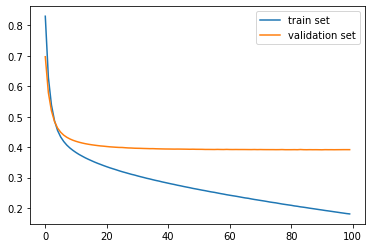

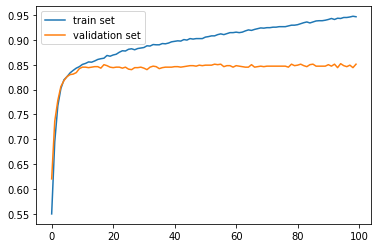

In [ ]:
# plot 

#history for loss
plt.plot(history.history["loss"],label="train set")
plt.plot(history.history["val_loss"],label="validation set")
plt.legend()
plt.show()

# summarize history for accuracy
plt.plot(history.history["accuracy"],label="train set")
plt.plot(history.history["val_accuracy"], label="validation set")
plt.legend()
plt.show()


We don't have the problem of overfitting anymore, but the accuracy has not changed. Thus, we try to change the neural network structure.

### Structure of the neural network : number of layers, number of neurons

In this part, we will try to vary the number of layers and the number of neurons in order to see if it can improve our mdoel.

We first try to modify the number of neurons in the first hidden layer, from 100 to 300. The activation functions remain the same. The learning rate is chosen at 10e-4 with the Adam optimizer.

In [ ]:
input_shape = ants_data[0].shape[0]
output_shape = 2

model = Sequential()
model.add(Dense(300, input_dim=input_shape))
model.add(Activation('relu'))
model.add(Dense(output_shape))
model.add(Activation('sigmoid'))

opt = optimizers.Adam(learning_rate = 0.0001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

epochs = 100

history = model.fit(norm_train, train_labels,epochs=epochs, batch_size = 10,validation_data =(norm_test,test_labels))

Epoch 1/100
200/200 [==============================] - 1s 4ms/step - loss: 0.5123 - accuracy: 0.7681 - val_loss: 0.4130 - val_accuracy: 0.8370
Epoch 2/100
200/200 [==============================] - 1s 3ms/step - loss: 0.3424 - accuracy: 0.8698 - val_loss: 0.4035 - val_accuracy: 0.8420
Epoch 3/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3045 - accuracy: 0.8873 - val_loss: 0.3989 - val_accuracy: 0.8450
Epoch 4/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2736 - accuracy: 0.8992 - val_loss: 0.3997 - val_accuracy: 0.8430
Epoch 5/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2368 - accuracy: 0.9209 - val_loss: 0.3897 - val_accuracy: 0.8450
Epoch 6/100
200/200 [==============================] - 1s 3ms/step - loss: 0.2162 - accuracy: 0.9337 - val_loss: 0.3918 - val_accuracy: 0.8540
Epoch 7/100
200/200 [==============================] - 1s 4ms/step - loss: 0.1880 - accuracy: 0.9421 - val_loss: 0.3950 - val_accuracy: 0.8500

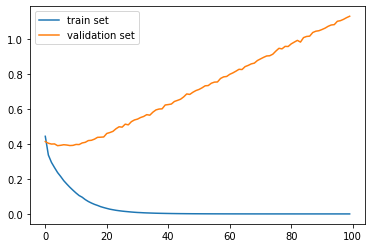

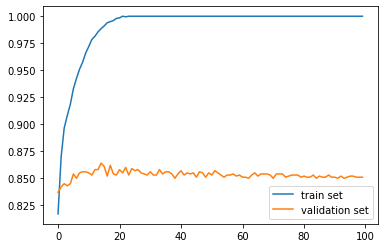

In [ ]:
# plot 

#history for loss
plt.plot(history.history["loss"],label="train set")
plt.plot(history.history["val_loss"],label="validation set")
plt.legend()
plt.show()

# summarize history for accuracy
plt.plot(history.history["accuracy"],label="train set")
plt.plot(history.history["val_accuracy"], label="validation set")
plt.legend()
plt.show()


We see once again a small improvement (from 0.84 to 0.85), however it is not enough for the moment. Plus, there is still overfitting. We try to see if increasing the number of neurons could improve our model again, from 300 to 400 in the hidden layer.

In [ ]:
input_shape = ants_data[0].shape[0]
output_shape = 2

model = Sequential()
model.add(Dense(400, input_dim=input_shape))
model.add(Activation('relu'))
model.add(Dense(output_shape))
model.add(Activation('sigmoid'))

opt = optimizers.Adam(learning_rate = 0.0001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

epochs = 100

history = model.fit(norm_train, train_labels,epochs=epochs, batch_size = 10,validation_data =(norm_test,test_labels))

Epoch 1/100
200/200 [==============================] - 1s 5ms/step - loss: 0.5593 - accuracy: 0.7096 - val_loss: 0.4102 - val_accuracy: 0.8420
Epoch 2/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3072 - accuracy: 0.8849 - val_loss: 0.3900 - val_accuracy: 0.8530
Epoch 3/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2794 - accuracy: 0.9078 - val_loss: 0.3913 - val_accuracy: 0.8460
Epoch 4/100
200/200 [==============================] - 1s 3ms/step - loss: 0.2493 - accuracy: 0.9089 - val_loss: 0.3866 - val_accuracy: 0.8490
Epoch 5/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2163 - accuracy: 0.9380 - val_loss: 0.3885 - val_accuracy: 0.8490
Epoch 6/100
200/200 [==============================] - 1s 4ms/step - loss: 0.1872 - accuracy: 0.9484 - val_loss: 0.3844 - val_accuracy: 0.8460
Epoch 7/100
200/200 [==============================] - 1s 3ms/step - loss: 0.1667 - accuracy: 0.9585 - val_loss: 0.3865 - val_accuracy: 0.8460

The results are the same. Thus, now we try to add a hidden layer to the neural network. We choose a hidden layer of 100 neurons, activated by a ReLU activation function. The neural network is as follows :

<center>$(784) \rightarrow (400) \rightarrow (100) \rightarrow (2)$</center>



In [ ]:
input_shape = ants_data[0].shape[0]
output_shape = 2

model = Sequential()
model.add(Dense(400, input_dim=input_shape))
model.add(Activation('relu'))
model.add(Dense(100))
model.add(Activation('sigmoid'))
model.add(Dense(output_shape))
model.add(Activation('sigmoid'))

opt = optimizers.Adam(learning_rate = 0.0001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

epochs = 100

history = model.fit(norm_train, train_labels,epochs=epochs, batch_size = 10,validation_data =(norm_test,test_labels))

Epoch 1/100
200/200 [==============================] - 2s 6ms/step - loss: 0.5358 - accuracy: 0.7631 - val_loss: 0.3957 - val_accuracy: 0.8490
Epoch 2/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3327 - accuracy: 0.8746 - val_loss: 0.3915 - val_accuracy: 0.8410
Epoch 3/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3221 - accuracy: 0.8880 - val_loss: 0.3785 - val_accuracy: 0.8460
Epoch 4/100
200/200 [==============================] - 1s 5ms/step - loss: 0.2826 - accuracy: 0.8977 - val_loss: 0.3772 - val_accuracy: 0.8500
Epoch 5/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2538 - accuracy: 0.9160 - val_loss: 0.3744 - val_accuracy: 0.8540
Epoch 6/100
200/200 [==============================] - 1s 5ms/step - loss: 0.2360 - accuracy: 0.9188 - val_loss: 0.3755 - val_accuracy: 0.8500
Epoch 7/100
200/200 [==============================] - 1s 4ms/step - loss: 0.2026 - accuracy: 0.9425 - val_loss: 0.3790 - val_accuracy: 0.8480

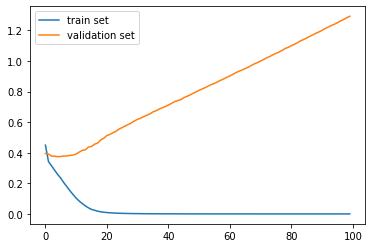

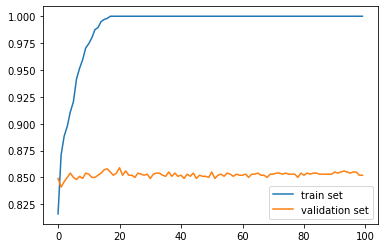

In [ ]:
# plot 

#history for loss
plt.plot(history.history["loss"],label="train set")
plt.plot(history.history["val_loss"],label="validation set")
plt.legend()
plt.show()

# summarize history for accuracy
plt.plot(history.history["accuracy"],label="train set")
plt.plot(history.history["val_accuracy"], label="validation set")
plt.legend()
plt.show()


However it seems like there is very few differences. This is why we will try another model. 

So far, the best results were with SGD with learning rate at 10e-4 and Adam at learning rate 10e-5 with a "simple" neural network. Now, instead of using simple neural networks, we will use Convolutional Neural Network (CNN) in the second part.

## **Convolutional Neural Network**

CNN are different from simple NN in many ways, including the shape of the input. This is why we must preprocess the data in order for it to fit in the CNN. Namely, we have to make sure the images have shape (28, 28, 1).

In [ ]:
# Preprocessing the data for CNN

x_train = [norm_train[i].reshape(28,28) for i in range(len(norm_train))]
x_test = [norm_test[i].reshape(28,28) for i in range(len(norm_test))]

# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

x_train shape: (2000, 28, 28, 1)
2000 train samples
1000 test samples


### Basic parameters of CNN

Now that our data has been preprocessed, we can try to implement our first CNN.

We use two hidden layers of (32), (64), each activated by a ReLU activation function, and the ouput is activated by sigmoid. We also use pooling in order to reduce the size of the images.

We first do 15 epoch in order to see how the CNN works with the Adam optimizer and its default parameters.


In [ ]:
# Model / data parameters
num_classes = 2
input_shape = (28, 28, 1)

model = Sequential(
    [
        Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(num_classes, activation="sigmoid"),
    ]
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 3202      
Total params: 22,018
Trainable params: 22,018
Non-trainable params: 0
__________________________________________________

In [ ]:
batch_size = 10
epochs = 15

opt = optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

history = model.fit(x_train, train_labels, batch_size=batch_size, epochs=epochs, validation_data =(x_test,test_labels))

Epoch 1/15
200/200 [==============================] - 3s 13ms/step - loss: 0.4854 - accuracy: 0.7569 - val_loss: 0.4327 - val_accuracy: 0.8190
Epoch 2/15
200/200 [==============================] - 2s 12ms/step - loss: 0.3032 - accuracy: 0.8765 - val_loss: 0.3112 - val_accuracy: 0.8850
Epoch 3/15
200/200 [==============================] - 2s 12ms/step - loss: 0.1996 - accuracy: 0.9240 - val_loss: 0.2856 - val_accuracy: 0.8860
Epoch 4/15
200/200 [==============================] - 2s 12ms/step - loss: 0.1704 - accuracy: 0.9387 - val_loss: 0.2776 - val_accuracy: 0.8970
Epoch 5/15
200/200 [==============================] - 2s 12ms/step - loss: 0.1449 - accuracy: 0.9487 - val_loss: 0.3304 - val_accuracy: 0.8730
Epoch 6/15
200/200 [==============================] - 2s 12ms/step - loss: 0.1225 - accuracy: 0.9636 - val_loss: 0.2759 - val_accuracy: 0.8860
Epoch 7/15
200/200 [==============================] - 2s 12ms/step - loss: 0.0974 - accuracy: 0.9703 - val_loss: 0.2851 - val_accuracy: 0.8860

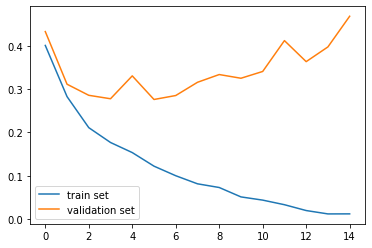

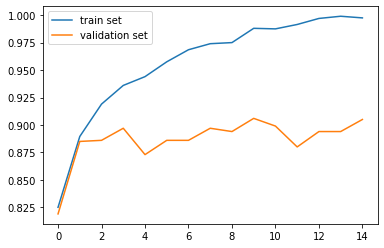

In [ ]:
# plot 

#history for loss
plt.plot(history.history["loss"],label="train set")
plt.plot(history.history["val_loss"],label="validation set")
plt.legend()
plt.show()

# summarize history for accuracy
plt.plot(history.history["accuracy"],label="train set")
plt.plot(history.history["val_accuracy"], label="validation set")
plt.legend()
plt.show()


We can already see that the results are better with a convolutional network. We went from an accuracy of 0.85 to 0.90. However, the loss is unstable and the validation loss increases. It means we're in a case of overfitting.

### Dropout

We will now also use the function Dropout to prevent overfitting. All the other parameters stay the same.

In [ ]:
# Model / data parameters
num_classes = 2
input_shape = (28, 28, 1)

model = Sequential(
    [
        Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="sigmoid"),
    ]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1600)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                

In [ ]:
batch_size = 10
epochs = 15

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(x_train, train_labels, batch_size=batch_size, epochs=epochs, validation_data =(x_test,test_labels))

Epoch 1/15
200/200 [==============================] - 3s 14ms/step - loss: 0.4744 - accuracy: 0.7767 - val_loss: 0.3484 - val_accuracy: 0.8720
Epoch 2/15
200/200 [==============================] - 2s 12ms/step - loss: 0.3226 - accuracy: 0.8729 - val_loss: 0.3064 - val_accuracy: 0.8890
Epoch 3/15
200/200 [==============================] - 3s 13ms/step - loss: 0.2358 - accuracy: 0.9062 - val_loss: 0.2923 - val_accuracy: 0.8890
Epoch 4/15
200/200 [==============================] - 3s 13ms/step - loss: 0.2087 - accuracy: 0.9191 - val_loss: 0.2705 - val_accuracy: 0.8960
Epoch 5/15
200/200 [==============================] - 3s 13ms/step - loss: 0.1811 - accuracy: 0.9286 - val_loss: 0.2609 - val_accuracy: 0.9020
Epoch 6/15
200/200 [==============================] - 2s 12ms/step - loss: 0.1611 - accuracy: 0.9380 - val_loss: 0.2550 - val_accuracy: 0.9070
Epoch 7/15
200/200 [==============================] - 2s 12ms/step - loss: 0.1377 - accuracy: 0.9517 - val_loss: 0.2790 - val_accuracy: 0.9020

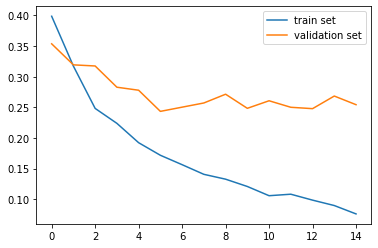

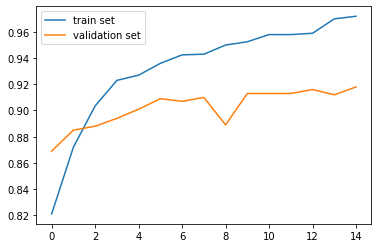

In [ ]:
# plot 

#history for loss
plt.plot(history.history["loss"],label="train set")
plt.plot(history.history["val_loss"],label="validation set")
plt.legend()
plt.show()

# summarize history for accuracy
plt.plot(history.history["accuracy"],label="train set")
plt.plot(history.history["val_accuracy"], label="validation set")
plt.legend()
plt.show()


With the Dropout function, we can see that the loss does not increase anymore. Since we only did 15 epoch, we can see how the CNN develops after a greater number of epoch.

### Increasing the number of epoch

We now increase the number of epoch to 50 to see if the accuracy increases or if there is overfitting.

In [ ]:
# Model / data parameters
num_classes = 2
input_shape = (28, 28, 1)

model = Sequential(
    [
        Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="sigmoid"),
    ]
)

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1600)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                

In [ ]:
batch_size = 10
epochs = 50

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(x_train, train_labels, batch_size=batch_size, epochs=epochs, validation_data =(x_test,test_labels))

Epoch 1/50
200/200 [==============================] - 3s 13ms/step - loss: 0.5368 - accuracy: 0.7360 - val_loss: 0.3680 - val_accuracy: 0.8680
Epoch 2/50
200/200 [==============================] - 2s 12ms/step - loss: 0.2943 - accuracy: 0.8770 - val_loss: 0.3133 - val_accuracy: 0.8690
Epoch 3/50
200/200 [==============================] - 2s 12ms/step - loss: 0.2389 - accuracy: 0.9126 - val_loss: 0.2749 - val_accuracy: 0.8930
Epoch 4/50
200/200 [==============================] - 2s 12ms/step - loss: 0.2170 - accuracy: 0.9176 - val_loss: 0.2888 - val_accuracy: 0.8930
Epoch 5/50
200/200 [==============================] - 2s 12ms/step - loss: 0.2023 - accuracy: 0.9224 - val_loss: 0.2502 - val_accuracy: 0.9060
Epoch 6/50
200/200 [==============================] - 2s 12ms/step - loss: 0.1740 - accuracy: 0.9349 - val_loss: 0.2607 - val_accuracy: 0.8980
Epoch 7/50
200/200 [==============================] - 2s 12ms/step - loss: 0.1557 - accuracy: 0.9461 - val_loss: 0.2307 - val_accuracy: 0.9160

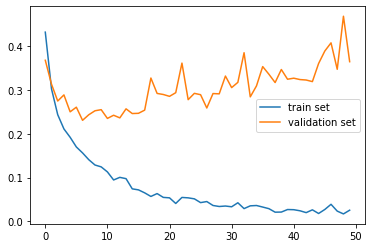

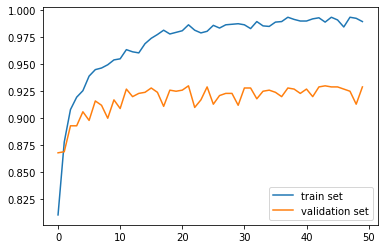

In [ ]:
# plot 

#history for loss
plt.plot(history.history["loss"],label="train set")
plt.plot(history.history["val_loss"],label="validation set")
plt.legend()
plt.show()

# summarize history for accuracy
plt.plot(history.history["accuracy"],label="train set")
plt.plot(history.history["val_accuracy"], label="validation set")
plt.legend()
plt.show()


The accuracy increased to 0.92 but there is obviously overfitting when we increase the number of epoch. Thus, we try to decrease the learning rate to avoid that.

### Learning rate

To avoid overfitting, we decrease the learning rate from 10e-3 to 10e-4. We increase the epoch to 70.

In [ ]:
# Model / data parameters
num_classes = 2
input_shape = (28, 28, 1)

model = Sequential(
    [
        Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="sigmoid"),
    ]
)

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 1600)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 2)                

In [ ]:
batch_size = 10
epochs = 70

opt = optimizers.Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

history = model.fit(x_train, train_labels, batch_size=batch_size, epochs=epochs, validation_data =(x_test,test_labels))

Epoch 1/70
200/200 [==============================] - 3s 13ms/step - loss: 0.6838 - accuracy: 0.5794 - val_loss: 0.5312 - val_accuracy: 0.8380
Epoch 2/70
200/200 [==============================] - 2s 12ms/step - loss: 0.5012 - accuracy: 0.8184 - val_loss: 0.4185 - val_accuracy: 0.8510
Epoch 3/70
200/200 [==============================] - 2s 12ms/step - loss: 0.4445 - accuracy: 0.8284 - val_loss: 0.3970 - val_accuracy: 0.8490
Epoch 4/70
200/200 [==============================] - 2s 12ms/step - loss: 0.3786 - accuracy: 0.8535 - val_loss: 0.3828 - val_accuracy: 0.8530
Epoch 5/70
200/200 [==============================] - 2s 12ms/step - loss: 0.3660 - accuracy: 0.8576 - val_loss: 0.3783 - val_accuracy: 0.8560
Epoch 6/70
200/200 [==============================] - 2s 12ms/step - loss: 0.3486 - accuracy: 0.8613 - val_loss: 0.3746 - val_accuracy: 0.8560
Epoch 7/70
200/200 [==============================] - 3s 13ms/step - loss: 0.3292 - accuracy: 0.8760 - val_loss: 0.3673 - val_accuracy: 0.8610

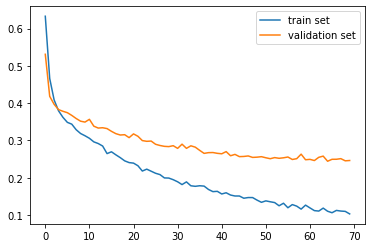

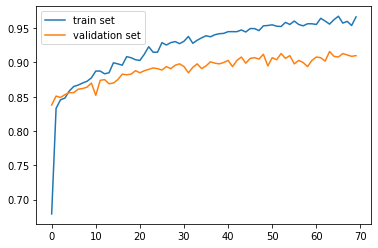

In [ ]:
# plot 

#history for loss
plt.plot(history.history["loss"],label="train set")
plt.plot(history.history["val_loss"],label="validation set")
plt.legend()
plt.show()

# summarize history for accuracy
plt.plot(history.history["accuracy"],label="train set")
plt.plot(history.history["val_accuracy"], label="validation set")
plt.legend()
plt.show()


We see that by decreasing the learning rate, we have removed overfitting from our model. The accuracy, however, has decreased from 0.92 to 0.90, so we will now work on how to improve it.

### Batch size

Since we do not have a massive dataset, we can try to reduce the batch size to see if we have better accuracy results.

In [ ]:
# Model / data parameters
num_classes = 2
input_shape = (28, 28, 1)

model = Sequential(
    [
        Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="sigmoid"),
    ]
)

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 1600)              0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 1600)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 2)               

In [ ]:
batch_size = 4
epochs = 70

opt = optimizers.Adam(learning_rate=0.0001)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(x_train, train_labels, batch_size=batch_size, epochs=epochs, validation_data =(x_test,test_labels))

Epoch 1/70
500/500 [==============================] - 4s 7ms/step - loss: 0.6265 - accuracy: 0.6871 - val_loss: 0.4413 - val_accuracy: 0.8360
Epoch 2/70
500/500 [==============================] - 3s 6ms/step - loss: 0.4202 - accuracy: 0.8429 - val_loss: 0.4068 - val_accuracy: 0.8440
Epoch 3/70
500/500 [==============================] - 3s 6ms/step - loss: 0.3633 - accuracy: 0.8648 - val_loss: 0.3795 - val_accuracy: 0.8510
Epoch 4/70
500/500 [==============================] - 3s 6ms/step - loss: 0.3598 - accuracy: 0.8523 - val_loss: 0.3671 - val_accuracy: 0.8610
Epoch 5/70
500/500 [==============================] - 3s 7ms/step - loss: 0.3224 - accuracy: 0.8697 - val_loss: 0.3584 - val_accuracy: 0.8640
Epoch 6/70
500/500 [==============================] - 3s 6ms/step - loss: 0.3192 - accuracy: 0.8717 - val_loss: 0.3525 - val_accuracy: 0.8700
Epoch 7/70
500/500 [==============================] - 3s 7ms/step - loss: 0.3072 - accuracy: 0.8876 - val_loss: 0.3517 - val_accuracy: 0.8690
Epoch 

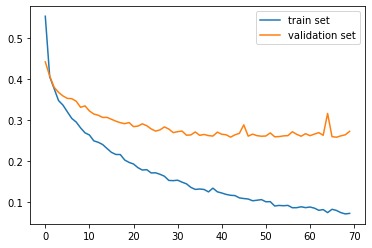

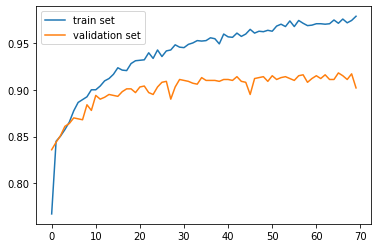

In [ ]:
# plot 

#history for loss
plt.plot(history.history["loss"],label="train set")
plt.plot(history.history["val_loss"],label="validation set")
plt.legend()
plt.show()

# summarize history for accuracy
plt.plot(history.history["accuracy"],label="train set")
plt.plot(history.history["val_accuracy"], label="validation set")
plt.legend()
plt.show()


The results are approximately the same than before (accuracy 0.91), so we can keep batch size to 10 since it computes faster.

### Changing the number of hidden layers

As a last experiment for this part, we will try to add a hidden layer to the CNN and see how it changes the behavior of the CNN. We thus will add another Conv2D layer of 64 neurons and activation function ReLU.

In [ ]:
# Model / data parameters
num_classes = 2
input_shape = (28, 28, 1)

model = Sequential(
    [
        Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="sigmoid"),
    ]
)

model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_12 (Flatten)         (None, 576)               0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 576)             

In [ ]:
batch_size = 10
epochs = 70

opt = optimizers.Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

history = model.fit(x_train, train_labels, batch_size=batch_size, epochs=epochs, validation_data =(x_test,test_labels))

Epoch 1/70
200/200 [==============================] - 3s 15ms/step - loss: 0.6468 - accuracy: 0.6469 - val_loss: 0.4527 - val_accuracy: 0.8460
Epoch 2/70
200/200 [==============================] - 3s 14ms/step - loss: 0.4089 - accuracy: 0.8441 - val_loss: 0.3970 - val_accuracy: 0.8310
Epoch 3/70
200/200 [==============================] - 3s 13ms/step - loss: 0.3804 - accuracy: 0.8529 - val_loss: 0.3686 - val_accuracy: 0.8560
Epoch 4/70
200/200 [==============================] - 3s 13ms/step - loss: 0.3448 - accuracy: 0.8708 - val_loss: 0.3649 - val_accuracy: 0.8540
Epoch 5/70
200/200 [==============================] - 3s 13ms/step - loss: 0.3315 - accuracy: 0.8664 - val_loss: 0.3544 - val_accuracy: 0.8620
Epoch 6/70
200/200 [==============================] - 3s 13ms/step - loss: 0.3148 - accuracy: 0.8755 - val_loss: 0.3434 - val_accuracy: 0.8700
Epoch 7/70
200/200 [==============================] - 3s 13ms/step - loss: 0.2972 - accuracy: 0.8841 - val_loss: 0.3474 - val_accuracy: 0.8710

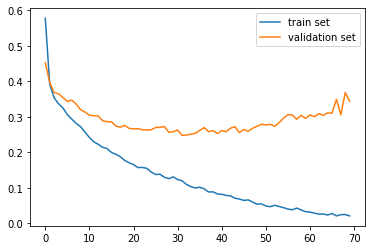

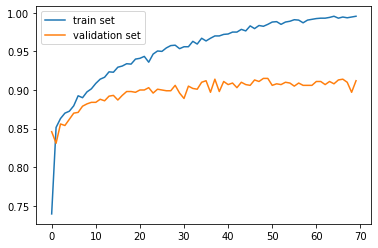

In [ ]:
# plot 

#history for loss
plt.plot(history.history["loss"],label="train set")
plt.plot(history.history["val_loss"],label="validation set")
plt.legend()
plt.show()

# summarize history for accuracy
plt.plot(history.history["accuracy"],label="train set")
plt.plot(history.history["val_accuracy"], label="validation set")
plt.legend()
plt.show()


Once again, the results are approximately the same for the accuracy. However, the loss increases : we start to overfit after a 60 epoch. We can therefore continue to use the previous CNN.

Now that we have worked on the construction of the CNN and saw which parameters optimized the accuracy while avoiding overfitting, we can now work on another way to increase accuracy.

## **CNN with data augmentation**

In this part, we will work on data augmentation, i.e. we will increase the dataset by adding images that are actually just edited image of the former dataset. Hence, we will add the same images, but rotated at some angle for example, or flipped horizontally.

### Rotate

We first create a function to rotate images given an angle. Then, we apply this function to all the images in the dataset, with an angle computed randomly for each image and we add it to the augmented dataset.

In [ ]:
# Method to rotate the image by given dimension
def rotate_image(image, rotation):
    image = image.reshape((28, 28))
    rot_image = interpolation.rotate(image, angle = rotation , mode="constant", reshape=False)
    return rot_image.reshape([-1])

In [ ]:
X_train_augmented = [image for image in train_images]
y_train_augmented = [image for image in train_labels]

for image, label in zip(train_images, train_labels):
  angle = np.random.randint(0,50)
  X_train_augmented.append(rotate_image(image, angle))
  y_train_augmented.append(label)

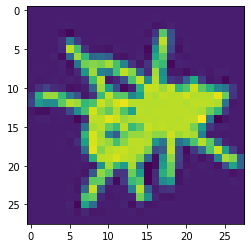

In [ ]:
plt.imshow(X_train_augmented[2000].reshape(28,28))

This is a rotated version of the first image of the ants dataset.

### Horizontal flip

In the same way, we create a function to flip the images horizontally and add these images to the augmented dataset.

In [ ]:
# Method to flip the image horizontally
def flip_image(image):
    image = image.reshape((28, 28))
    flip_image = np.flip(image,1)
    return flip_image.reshape([-1])

In [ ]:
for image, label in zip(train_images, train_labels):
  X_train_augmented.append(flip_image(image))
  y_train_augmented.append(label)

In [ ]:
y_train_augmented = np.array(y_train_augmented)

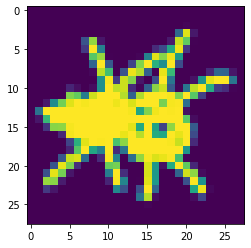

In [ ]:
plt.imshow(flip_image(X_train_augmented[0]).reshape(28,28))

This is the horizontally flipped version of the first image of the ants dataset.

### Test with CNN

Now, we can test the CNN with the augmented dataset, but not before preprocessing the dataset again (normalizing and reshaping).

In [ ]:
# Preprocessing the data for CNN

# Normalizing
norm_train_augmented = (X_train_augmented - np.mean(X_train_augmented))/np.std(X_train_augmented)
norm_test = (test_images - np.mean(train_images))/np.std(train_images)

x_train = np.array([norm_train_augmented[i].reshape(28,28) for i in range(len(norm_train_augmented))])
x_test = np.array([norm_test[i].reshape(28,28) for i in range(len(norm_test))])

# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

x_train shape: (6000, 28, 28, 1)
6000 train samples
1000 test samples


We now have 6000 train samples instead of 2000 with data augmentation.

In [ ]:
# Model / data parameters
num_classes = 2
input_shape = (28, 28, 1)

model = Sequential(
    [
        Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="sigmoid"),
    ]
)

model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 1600)              0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 1600)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 2)               

In [ ]:
batch_size = 10
epochs = 70

opt = optimizers.Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

history = model.fit(x_train, y_train_augmented, batch_size=batch_size, epochs=epochs, validation_data =(x_test,test_labels))

Epoch 1/70
600/600 [==============================] - 8s 12ms/step - loss: 0.5887 - accuracy: 0.7180 - val_loss: 0.4060 - val_accuracy: 0.8430
Epoch 2/70
600/600 [==============================] - 7s 12ms/step - loss: 0.4165 - accuracy: 0.8325 - val_loss: 0.3798 - val_accuracy: 0.8490
Epoch 3/70
600/600 [==============================] - 7s 12ms/step - loss: 0.3686 - accuracy: 0.8499 - val_loss: 0.3642 - val_accuracy: 0.8590
Epoch 4/70
600/600 [==============================] - 7s 12ms/step - loss: 0.3680 - accuracy: 0.8535 - val_loss: 0.3513 - val_accuracy: 0.8620
Epoch 5/70
600/600 [==============================] - 7s 12ms/step - loss: 0.3426 - accuracy: 0.8605 - val_loss: 0.3374 - val_accuracy: 0.8680
Epoch 6/70
600/600 [==============================] - 7s 12ms/step - loss: 0.3098 - accuracy: 0.8795 - val_loss: 0.3260 - val_accuracy: 0.8670
Epoch 7/70
600/600 [==============================] - 7s 12ms/step - loss: 0.2961 - accuracy: 0.8826 - val_loss: 0.3127 - val_accuracy: 0.8840

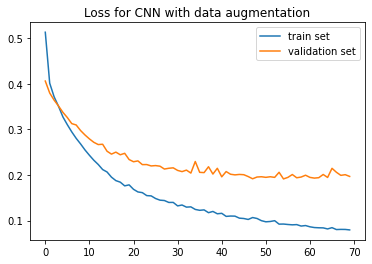

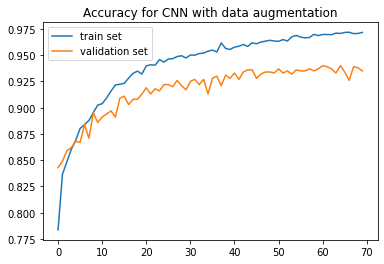

In [ ]:
# plot 

#history for loss
plt.plot(history.history["loss"],label="train set")
plt.plot(history.history["val_loss"],label="validation set")
plt.title("Loss for CNN with data augmentation")
plt.legend()
plt.show()

# summarize history for accuracy
plt.plot(history.history["accuracy"],label="train set")
plt.plot(history.history["val_accuracy"], label="validation set")
plt.title("Accuracy for CNN with data augmentation")
plt.legend()
plt.show()


Finally, with data augmentation, our validation accuracy is up to 0.93, almost 0.94, which improved our previous model of 4%. The loss is also decreasing, meaning we are not overfitting. 

## **Conclusion**

With SVM, our best result was with an **RBF kernel**, without PCA. The accuracy was **0.867**.

With Neural Network, our best result was with a **Convolutional Neural Network, with data augmentation**. The training accuracy was **0.973** and the validation accuracy was **0.935** after 70 epoch.